In [1]:
#Build a classifier to predict the condition of a water well, 
#using information about the sort of pump, when it was installed, etc. 
#Your audience could be an NGO focused on locating wells needing repair, 
#or the Government of Tanzania looking to find patterns in non-functional wells 
#to influence how new wells are built. Note that this is a ternary classification problem 
#by default, but can be engineered to be binary.

In [ ]:
#Loading packages 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#read in the test values data and set id as the index
test_value_df = pd.read_csv("/Users/arun/Desktop/Flatiron/Projects/Phase3_Project/Test_set_values.csv", index_col = 0)

In [8]:
#read in the training values data and set id as the index
training_value_df = pd.read_csv('/Users/arun/Desktop/Flatiron/Projects/Phase3_Project/Training_set_values.csv', index_col = 0)

#read in the training labels data and set id as the index
training_label_df = pd.read_csv('/Users/arun/Desktop/Flatiron/Projects/Phase3_Project/Training_set_labels.csv', index_col = 0)

#combine the training datasets
training_df = pd.concat([training_value_df, training_label_df], axis=1)

# EDA

In [69]:
#A few missing values, possible redundant data in multiple columns.
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

In [9]:
#big range in values for construction year, population
#possible outliers in amount_tsh and big range in population and construction year.
#Multiple columns have 0 as a value.

training_df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [71]:
#look for null values in the dataset
training_df.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [72]:
#Count number of zeros in all columns of Dataframe
#significant amount of zeros in multiple columns. Looks like num_private can be dropped as a start

#amount_tsh will need some sort of imputing 
#construction year has no NA values but does have over 20K zero values.

for column_name in training_df.columns:
    column = training_df[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print('Count of zeros in column in', column_name, ' is : ', count)

Count of zeros in column in amount_tsh  is :  41639
Count of zeros in column in date_recorded  is :  0
Count of zeros in column in funder  is :  0
Count of zeros in column in gps_height  is :  20438
Count of zeros in column in installer  is :  0
Count of zeros in column in longitude  is :  1812
Count of zeros in column in latitude  is :  0
Count of zeros in column in wpt_name  is :  0
Count of zeros in column in num_private  is :  58643
Count of zeros in column in basin  is :  0
Count of zeros in column in subvillage  is :  0
Count of zeros in column in region  is :  0
Count of zeros in column in region_code  is :  0
Count of zeros in column in district_code  is :  23
Count of zeros in column in lga  is :  0
Count of zeros in column in ward  is :  0
Count of zeros in column in population  is :  21381
Count of zeros in column in public_meeting  is :  5055
Count of zeros in column in recorded_by  is :  0
Count of zeros in column in scheme_management  is :  0
Count of zeros in column in s

In [55]:
#The target variable is status_group.

#54.30% of the pumps are funtional
#38.42% of the pumps are non functional
#7.26% of the pumps need repair

print(training_df['status_group'].value_counts())

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


In [74]:
#There are 6 different variables for Geographic location not including Long/Lat.

print('region count:' ,len(training_df['region'].unique()))

#region code count has more categories then region count
print('region code count:', len(training_df['region_code'].unique()))

#district code has 23 0 values but still might be better to use because of numerical values
print('district code count:', len(training_df['district_code'].unique()))

region count: 21
region code count: 27
district code count: 20


In [75]:
#scheme_management and scheme_name are data for who operates the waterpoint
#Scheme_name has alot more None values, but the scheme_mangement has vague categories like company and other

print('scheme_management:' ,len(training_df['scheme_management'].unique()))
print(training_df['scheme_management'].value_counts())

print('----------------------------------------------')

print('scheme_name:' ,len(training_df['scheme_name'].unique()))
print(training_df['scheme_name'].value_counts())



scheme_management: 13
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64
----------------------------------------------
scheme_name: 2697
K                                  682
None                               644
Borehole                           546
Chalinze wate                      405
M                                  400
                                  ... 
Chikombo water supply                1
Njalamatatawater gravity scheme      1
PIDP                                 1
Heshivu water supply                 1
UHEKULE                              1
Name: scheme_name, Length: 2696, dtype: int64


In [37]:
#extraction_type, extraction_type_group and extraction_type_class seem very similar as well
#They all have no null values and don't contain 0 as a value 
#going to use just extraction_type since it has the most categories

print('extraction_type:' ,len(training_df['extraction_type'].unique()))
print(training_df['extraction_type'].value_counts())
print('----------------------------------------------')
print('extraction_type_group:' ,len(training_df['extraction_type_group'].unique()))
print(training_df['extraction_type_group'].value_counts())
print('----------------------------------------------')
print('extraction_type_class:' ,len(training_df['extraction_type_class'].unique()))
print(training_df['extraction_type_class'].value_counts())

extraction_type: 18
gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64
----------------------------------------------
extraction_type_group: 13
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump  

In [41]:
#how the waterpoint is managed also has similar data
#going to use management

print('management:' ,len(training_df['management'].unique()))
print(training_df['management'].value_counts())
print('----------------------------------------------')
print('management_group:' ,len(training_df['management_group'].unique()))
print(training_df['management_group'].value_counts())

management: 12
vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64
----------------------------------------------
management_group: 5
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64


In [76]:
#payment has 2 variables as well, seem identical

print('payment:' ,len(training_df['payment'].unique()))
print(training_df['payment'].value_counts())
print('--------------------------------------------------------')
print('payment_type:' ,len(training_df['payment_type'].unique()))
print(training_df['payment_type'].value_counts())

payment: 7
never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64
--------------------------------------------------------
payment_type: 7
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64


In [43]:
#water quality also has 2 variables
#water_quality will be better because I want to remove the abandoned wells

print('water_quality:' ,len(training_df['water_quality'].unique()))
print(training_df['water_quality'].value_counts())
print('----------------------------------------------')
print('quality_group:' ,len(training_df['quality_group'].unique()))
print(training_df['quality_group'].value_counts())

water_quality: 8
soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64
----------------------------------------------
quality_group: 6
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64


In [47]:
#water quantity also has 2 variables
#identical, will use quantity 

print('quantity:' ,len(training_df['quantity'].unique()))
print(training_df['quantity'].value_counts())
print('----------------------------------------------')
print('quantity_group :' ,len(training_df['quantity_group'].unique()))
print(training_df['quantity_group'].value_counts())

quantity: 5
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64
----------------------------------------------
quantity_group : 5
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64


In [48]:
#there are 3 varaibles for water source
#going to use source, less unknowns and more granular categories

print('source:' ,len(training_df['source'].unique()))
print(training_df['source'].value_counts())
print('----------------------------------------------')
print('source_type:' ,len(training_df['source_type'].unique()))
print(training_df['source_type'].value_counts())
print('----------------------------------------------')
print('source_class:' ,len(training_df['source_class'].unique()))
print(training_df['source_class'].value_counts())

source: 10
spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64
----------------------------------------------
source_type: 7
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64
----------------------------------------------
source_class: 3
groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64


In [49]:
#waterpoint also has 2 variables
#not su
print('waterpoint_type' ,len(training_df['waterpoint_type'].unique()))
print(training_df['waterpoint_type'].value_counts())
print('----------------------------------------------')
print('waterpoint_type_group:' ,len(training_df['waterpoint_type_group'].unique()))
print(training_df['waterpoint_type_group'].value_counts())

waterpoint_type 7
communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
----------------------------------------------
waterpoint_type_group: 6
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64


In [92]:
#columns to keep for a cleaner dataset. Dropped columns that either had redundant data, or many null/0 values.

keep_columns = ['status_group','amount_tsh','date_recorded','funder','installer','longitude','latitude','wpt_name',
                'basin','region_code','district_code','recorded_by','scheme_management','extraction_type','management',
                'payment','water_quality','quantity','source','waterpoint_type']

df = training_df[keep_columns]

In [93]:
#only 20 coumns now
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status_group       59400 non-null  object 
 1   amount_tsh         59400 non-null  float64
 2   date_recorded      59400 non-null  object 
 3   funder             55765 non-null  object 
 4   installer          55745 non-null  object 
 5   longitude          59400 non-null  float64
 6   latitude           59400 non-null  float64
 7   wpt_name           59400 non-null  object 
 8   basin              59400 non-null  object 
 9   region_code        59400 non-null  int64  
 10  district_code      59400 non-null  int64  
 11  recorded_by        59400 non-null  object 
 12  scheme_management  55523 non-null  object 
 13  extraction_type    59400 non-null  object 
 14  management         59400 non-null  object 
 15  payment            59400 non-null  object 
 16  water_quality     

In [94]:
#These columns still have some null values to deal with.
df.isna().sum()

status_group            0
amount_tsh              0
date_recorded           0
funder               3635
installer            3655
longitude               0
latitude                0
wpt_name                0
basin                   0
region_code             0
district_code           0
recorded_by             0
scheme_management    3877
extraction_type         0
management              0
payment                 0
water_quality           0
quantity                0
source                  0
waterpoint_type         0
dtype: int64

In [97]:
#drop the null values in the dataset
df.dropna(axis = 0, inplace = True)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51880 entries, 69572 to 26348
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status_group       51880 non-null  object 
 1   amount_tsh         51880 non-null  float64
 2   date_recorded      51880 non-null  object 
 3   funder             51880 non-null  object 
 4   installer          51880 non-null  object 
 5   longitude          51880 non-null  float64
 6   latitude           51880 non-null  float64
 7   wpt_name           51880 non-null  object 
 8   basin              51880 non-null  object 
 9   region_code        51880 non-null  int64  
 10  district_code      51880 non-null  int64  
 11  recorded_by        51880 non-null  object 
 12  scheme_management  51880 non-null  object 
 13  extraction_type    51880 non-null  object 
 14  management         51880 non-null  object 
 15  payment            51880 non-null  object 
 16  water_quality     

In [99]:
#look at how many 0's in remaining columns 
for column_name in df.columns:
    column = df[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print('Count of zeros in column in', column_name, ' is : ', count)

Count of zeros in column in status_group  is :  0
Count of zeros in column in amount_tsh  is :  35168
Count of zeros in column in date_recorded  is :  0
Count of zeros in column in funder  is :  0
Count of zeros in column in installer  is :  0
Count of zeros in column in longitude  is :  1671
Count of zeros in column in latitude  is :  0
Count of zeros in column in wpt_name  is :  0
Count of zeros in column in basin  is :  0
Count of zeros in column in region_code  is :  0
Count of zeros in column in district_code  is :  23
Count of zeros in column in recorded_by  is :  0
Count of zeros in column in scheme_management  is :  0
Count of zeros in column in extraction_type  is :  0
Count of zeros in column in management  is :  0
Count of zeros in column in payment  is :  0
Count of zeros in column in water_quality  is :  0
Count of zeros in column in quantity  is :  0
Count of zeros in column in source  is :  0
Count of zeros in column in waterpoint_type  is :  0


In [100]:
df.describe()

,amount_tsh,longitude,latitude,region_code,district_code
count,51880.000000,51880.000000,5.188000e+04,51880.000000,51880.000000
mean,344.907992,34.067045,-5.633394e+00,14.833308,5.650173
std,2802.632595,6.740621,2.930362e+00,17.086912,9.548364
min,0.000000,0.000000,-1.164944e+01,1.000000,0.000000
25%,0.000000,33.069757,-8.135600e+00,5.000000,2.000000
50%,0.000000,35.080114,-4.934010e+00,12.000000,3.000000
75%,30.000000,37.324569,-3.311001e+00,17.000000,5.000000
max,250000.000000,40.323402,-2.000000e-08,99.000000,80.000000


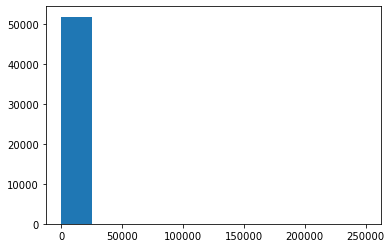

In [105]:
#the data is heavily skewed, going to use the median 
fig, ax = plt.subplots()
ax.hist(df['amount_tsh'])
plt.show()

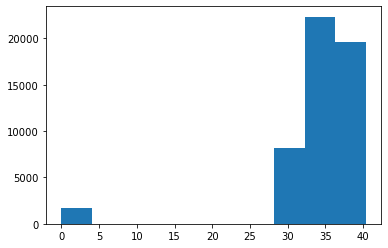

In [106]:
#heavily skewed data, going to input the median for missing values.
fig, ax = plt.subplots()
ax.hist(df['longitude'])
plt.show()

# Data Wrangling 